In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from glob import glob
%matplotlib inline
import matplotlib.pyplot as plt
from itertools import chain
from random import sample 

##Import any other stats/DL/ML packages you may need here. E.g. Keras, scikit-learn, etc.
import tensorflow as tf
from skimage import io
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve,auc,precision_recall_curve,average_precision_score
from sklearn.metrics import f1_score, recall_score
from sklearn.preprocessing import binarize

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau

In [2]:
# set default plot style
plt.style.use('ggplot')

## Do some early processing of your metadata for easier model training:

In [3]:
## Below is some helper code to read all of your full image filepaths into a dataframe for easier manipulation
## Load the NIH data to all_xray_df
all_xray_df = pd.read_csv('/data/Data_Entry_2017.csv')
all_image_paths = {os.path.basename(x): x for x in 
                   glob(os.path.join('/data','images*', '*', '*.png'))}
print('Scans found:', len(all_image_paths), ', Total Headers', all_xray_df.shape[0])
all_xray_df['path'] = all_xray_df['Image Index'].map(all_image_paths.get)
all_xray_df.sample(3)

Scans found: 112120 , Total Headers 112120


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11,path
32490,00008490_003.png,Fibrosis|Infiltration,3,8490,58,M,PA,2992,2991,0.143,0.143,NaN,/data/images_004/images/00008490_003.png
72898,00017972_005.png,No Finding,5,17972,15,M,AP,3056,2544,0.139,0.139,NaN,/data/images_008/images/00017972_005.png
79517,00019530_012.png,No Finding,12,19530,40,M,AP,2500,2048,0.168,0.168,NaN,/data/images_009/images/00019530_012.png


In [4]:
## Here you may want to create some extra columns in your table with binary indicators of certain diseases 
## rather than working directly with the 'Finding Labels' column

# Extract finding labels for per disease distribution
all_labels = np.unique(list(chain(*all_xray_df['Finding Labels'].map(lambda x: x.split('|')).tolist())))
all_labels = [x for x in all_labels if len(x)>0]

print('All Labels ({}): {}'.format(len(all_labels), all_labels))

for c_label in all_labels:
    if len(c_label)>1: # leave out empty labels
        all_xray_df[(c_label+'_class').lower()] = all_xray_df['Finding Labels'].map(lambda finding: 1.0 if c_label in finding else 0)

all_xray_df.sample(3)

All Labels (15): ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'No Finding', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,emphysema_class,fibrosis_class,hernia_class,infiltration_class,mass_class,no finding_class,nodule_class,pleural_thickening_class,pneumonia_class,pneumothorax_class
85570,00021099_000.png,No Finding,0,21099,60,M,PA,3056,2544,0.139,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
47143,00012012_001.png,Pneumothorax,1,12012,42,F,PA,2992,2991,0.143,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
64314,00015863_002.png,Mass,2,15863,11,F,PA,2048,2500,0.168,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


## Create your training and testing data:

In [5]:
def create_splits(df, test_size, column_name):
    
    ## Either build your own or use a built-in library to split your original dataframe into two sets 
    ## that can be used for training and testing your model
    ## It's important to consider here how balanced or imbalanced you want each of those sets to be
    ## for the presence of pneumonia
    
    train_data, val_data = train_test_split(df, 
                                            test_size = test_size, 
                                            stratify = df[column_name])
    
    return train_data, val_data

In [6]:
train_df, val_df = create_splits(all_xray_df, 0.2, 'pneumonia_class')

In [7]:
# check class balance for training set
print('Number of pneumonia cases: {}'.format(len(train_df[train_df.pneumonia_class==1.0])))
print('Number of non-pneumonia cases: {}'.format(len(train_df[train_df.pneumonia_class==0.0])))
print('Percentage of pneumonia cases in train set {:0.4f}'.format(train_df['pneumonia_class'].sum()/len(train_df)))

Number of pneumonia cases: 1145
Number of non-pneumonia cases: 88551
Percentage of pneumonia cases in train set 0.0128


In [8]:
# check class balance for validation set
print('Number of pneumonia cases: {}'.format(len(val_df[val_df.pneumonia_class==1.0])))
print('Number of non-pneumonia cases: {}'.format(len(val_df[val_df.pneumonia_class==0.0])))
print('Percentage of pneumonia cases in validation set {:0.4f}'.format(val_df['pneumonia_class'].sum()/len(val_df)))

Number of pneumonia cases: 286
Number of non-pneumonia cases: 22138
Percentage of pneumonia cases in validation set 0.0128


In [9]:
# make equal proportion of pneumonia and non-pneumonia cases in training set
p_inds = train_df[train_df.pneumonia_class==1].index.tolist()
np_inds = train_df[train_df.pneumonia_class==0].index.tolist()

np_sample = sample(np_inds,len(p_inds))
train_df = train_df.loc[p_inds + np_sample]

print('New percentage of pneumonia cases in train set {:0.2f}'.format(train_df['pneumonia_class'].sum()/len(train_df)))

New percentage of pneumonia cases in train set 0.50


In [10]:
# model unbalance proportion of pneumonia and non-pneumonia cases in validation set
p_inds = val_df[val_df.pneumonia_class==1].index.tolist()
np_inds = val_df[val_df.pneumonia_class==0].index.tolist()

# The following code pulls a random sample of non-pneumonia data that's 4 times as big as the pneumonia sample.
np_sample = sample(np_inds,4*len(p_inds))
val_df = val_df.loc[p_inds + np_sample]

print('New percentage of pneumonia cases in train set {:0.2f}'.format(val_df['pneumonia_class'].sum()/len(val_df)))

New percentage of pneumonia cases in train set 0.20


Patient distribution in training set
M    1325
F     965
Name: Patient Gender, dtype: int64


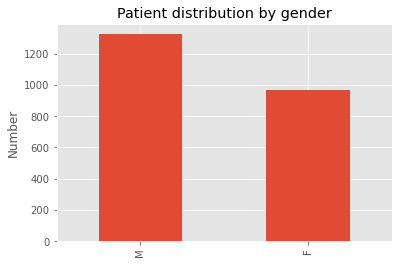

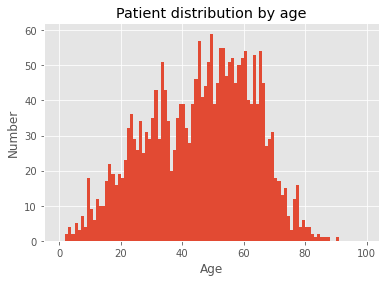

In [15]:
print('Patient distribution in training set')
print(train_df['Patient Gender'].value_counts())
plt.title('Patient distribution by gender')
plt.ylabel('Number')
train_df['Patient Gender'].value_counts().plot(kind='bar')
plt.show()

plt.title('Patient distribution by age')
plt.xlabel('Age')
plt.ylabel('Number')
train_df['Patient Age'].hist(bins=np.arange(0, 100))
plt.show()

Patient distribution in validation set
M    810
F    620
Name: Patient Gender, dtype: int64


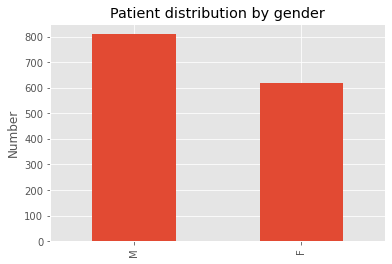

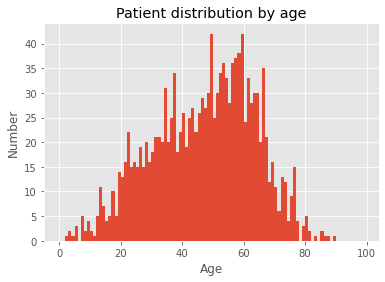

In [16]:
print('Patient distribution in validation set')
print(val_df['Patient Gender'].value_counts())
plt.title('Patient distribution by gender')
plt.ylabel('Number')
val_df['Patient Gender'].value_counts().plot(kind='bar')
plt.show()

plt.title('Patient distribution by age')
plt.xlabel('Age')
plt.ylabel('Number')
val_df['Patient Age'].hist(bins=np.arange(0, 100))
plt.show()

# Now we can begin our model-building & training

#### First suggestion: perform some image augmentation on your data

In [17]:
train_df.columns

Index(['Image Index', 'Finding Labels', 'Follow-up #', 'Patient ID',
       'Patient Age', 'Patient Gender', 'View Position', 'OriginalImage[Width',
       'Height]', 'OriginalImagePixelSpacing[x', 'y]', 'Unnamed: 11', 'path',
       'atelectasis_class', 'cardiomegaly_class', 'consolidation_class',
       'edema_class', 'effusion_class', 'emphysema_class', 'fibrosis_class',
       'hernia_class', 'infiltration_class', 'mass_class', 'no finding_class',
       'nodule_class', 'pleural_thickening_class', 'pneumonia_class',
       'pneumothorax_class'],
      dtype='object')

In [18]:
def my_image_augmentation():
    
    ## recommendation here to implement a package like Keras' ImageDataGenerator
    ## with some of the built-in augmentations 
    
    
    ## keep an eye out for types of augmentation that are or are not appropriate for medical imaging data
    ## Also keep in mind what sort of augmentation is or is not appropriate for testing vs validation data
    
    ## STAND-OUT SUGGESTION: implement some of your own custom augmentation that's *not*
    ## built into something like a Keras package
    
    my_idg = ImageDataGenerator(rescale = 1./255.0,
                                horizontal_flip = True, 
                                vertical_flip = False, 
                                height_shift_range = 0.1, 
                                width_shift_range = 0.1, 
                                rotation_range = 20, 
                                shear_range = 0.1,
                                zoom_range = 0.1)
    
    return my_idg


def make_train_gen(df, img_size, batch_size):
    
    ## Create the actual generators using the output of my_image_augmentation for your training data
    ## Suggestion here to use the flow_from_dataframe library, e.g.:
    
    my_train_idg = my_image_augmentation()
    train_gen = my_train_idg.flow_from_dataframe(dataframe = df, 
                                                 directory = None, 
                                                 x_col = 'path',
                                                 y_col = 'pneumonia_class',
                                                 class_mode = 'raw',
                                                 target_size = img_size, 
                                                 batch_size = batch_size)

    return train_gen


def make_val_gen(df, img_size, batch_size):
    
    my_val_idg = ImageDataGenerator(rescale = 1./255.0)
    val_gen = my_val_idg.flow_from_dataframe(dataframe = df, 
                                             directory = None, 
                                             x_col = 'path',
                                             y_col = 'pneumonia_class',
                                             class_mode = 'raw',
                                             target_size = img_size, 
                                             batch_size = batch_size) 
    
    return val_gen

In [19]:
# call data generators for training and validation set
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

train_gen = make_train_gen(train_df, IMG_SIZE, BATCH_SIZE)
val_gen = make_val_gen(val_df, IMG_SIZE, BATCH_SIZE)

Found 2290 validated image filenames.
Found 1430 validated image filenames.


In [20]:
## May want to pull a single large batch of random validation data for testing after each epoch:
valX, valY = val_gen.next()

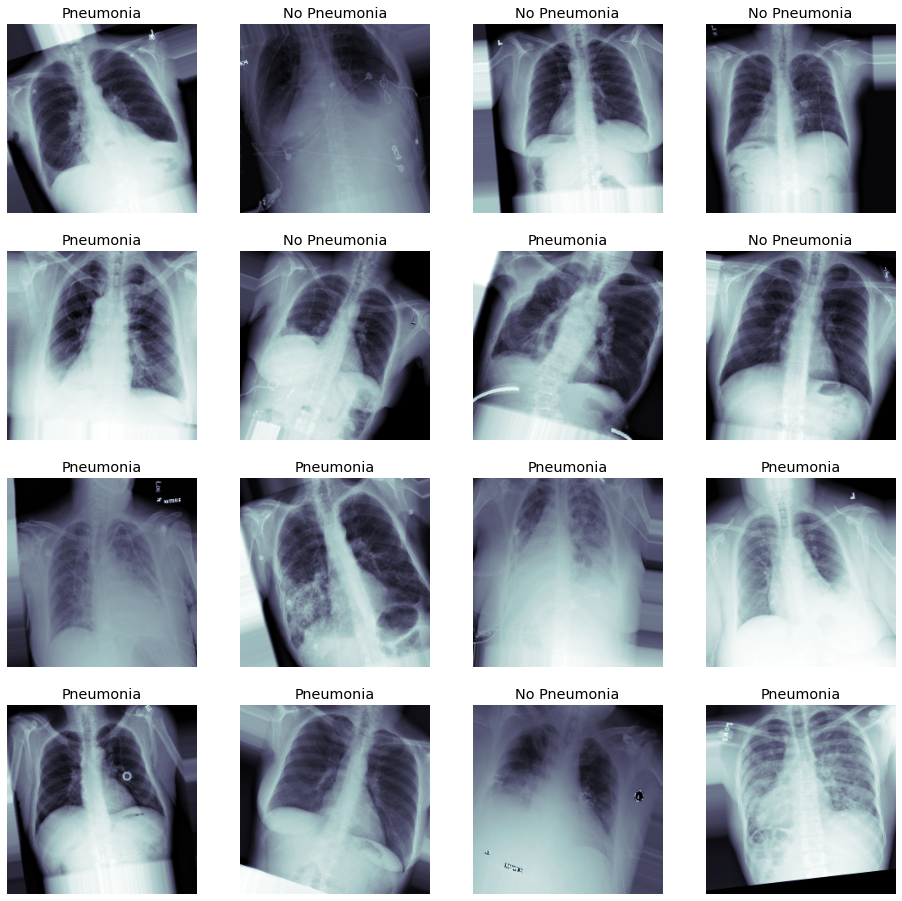

In [21]:
## May want to look at some examples of our augmented training data. 
## This is helpful for understanding the extent to which data is being manipulated prior to training, 
## and can be compared with how the raw data look prior to augmentation

t_x, t_y = next(train_gen)
fig, m_axs = plt.subplots(4, 4, figsize = (16, 16))
for (c_x, c_y, c_ax) in zip(t_x, t_y, m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = 'bone')
    if c_y == 1: 
        c_ax.set_title('Pneumonia')
    else:
        c_ax.set_title('No Pneumonia')
    c_ax.axis('off')

## Build your model: 

Recommendation here to use a pre-trained network downloaded from Keras for fine-tuning

In [22]:
def load_pretrained_model(layer_of_interest):
    
    model = VGG16(include_top=True, weights='imagenet')
    transfer_layer = model.get_layer(layer_of_interest)
    vgg_model = Model(inputs = model.input, outputs = transfer_layer.output)
    
    for layer in vgg_model.layers[0:17]:
        layer.trainable = False
    
    return vgg_model

In [23]:
def build_my_model():
    
    # my_model = Sequential()
    # ....add your pre-trained model, and then whatever additional layers you think you might
    # want for fine-tuning (Flatteen, Dense, Dropout, etc.)
    
    # if you want to compile your model within this function, consider which layers of your pre-trained model, 
    # you want to freeze before you compile 
    
    # also make sure you set your optimizer, loss function, and metrics to monitor
    
    # Todo
    vgg_model = load_pretrained_model('block5_pool')
    
    my_model = Sequential([vgg_model,
                           Flatten(),
                           Dropout(0.5),
                           Dense(1024, activation='relu'),
                           Dropout(0.5),
                           Dense(512, activation='relu'),
                           Dropout(0.5),
                           Dense(256, activation='relu'),
                           Dense(1, activation='sigmoid')])
    
    return my_model


## STAND-OUT Suggestion: choose another output layer besides just the last classification layer of your modele
## to output class activation maps to aid in clinical interpretation of your model's results

In [24]:
model = build_my_model()
model.summary()

553467904/553467096 [==============================] - 7s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model (Model)                (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 25088)             0         
_________________________________________________________________
dropout (Dropout)            (None, 25088)             0         
_________________________________________________________________
dense (Dense)                (None, 1024)              25691136  
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               524800    
_______________________________________________________

In [25]:
optimizer = Adam(lr=1e-3)
loss = 'binary_crossentropy'
metrics = ['binary_accuracy']

model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

In [26]:
## Below is some helper code that will allow you to add checkpoints to your model,
## This will save the 'best' version of your model by comparing it to previous epochs of training

## Note that you need to choose which metric to monitor for your model's 'best' performance if using this code. 
## The 'patience' parameter is set to 10, meaning that your model will train for ten epochs without seeing
## improvement before quitting

weight_path="{}_my_model.best.hdf5".format('xray_class')

checkpoint = ModelCheckpoint(weight_path, 
                             monitor= 'val_loss', 
                             verbose=1, 
                             save_best_only=True, 
                             mode= 'auto', 
                             save_weights_only = True)

early = EarlyStopping(monitor= 'val_loss', 
                      mode= 'auto', 
                      patience=10)

callbacks_list = [checkpoint, early]

### Start training! 

In [27]:
## train your model

history = model.fit_generator(train_gen, 
                              validation_data = (valX, valY), 
                              epochs = 10, 
                              callbacks = callbacks_list)

Instructions for updating:
Please use Model.fit, which supports generators.
  ...
    to  
  ['...']
Train for 72 steps, validate on 32 samples
Epoch 1/10
71/72 [============================>.] - ETA: 0s - loss: 0.8173 - binary_accuracy: 0.5115
Epoch 00001: val_loss improved from inf to 0.66462, saving model to xray_class_my_model.best.hdf5
72/72 [==============================] - 68s 944ms/step - loss: 0.8156 - binary_accuracy: 0.5122 - val_loss: 0.6646 - val_binary_accuracy: 0.5938
Epoch 2/10
71/72 [============================>.] - ETA: 0s - loss: 0.6847 - binary_accuracy: 0.5660
Epoch 00002: val_loss improved from 0.66462 to 0.56784, saving model to xray_class_my_model.best.hdf5
72/72 [==============================] - 58s 803ms/step - loss: 0.6854 - binary_accuracy: 0.5646 - val_loss: 0.5678 - val_binary_accuracy: 0.7188
Epoch 3/10
71/72 [============================>.] - ETA: 0s - loss: 0.6861 - binary_accuracy: 0.5633
Epoch 00003: val_loss did not improve from 0.56784
72/72 [===

##### After training for some time, look at the performance of your model by plotting some performance statistics:

Note, these figures will come in handy for your FDA documentation later in the project

In [28]:
## After training, make some predictions to assess your model's overall performance
## Note that detecting pneumonia is hard even for trained expert radiologists, 
## so there is no need to make the model perfect.
val_Y = val_df['pneumonia_class']
model.load_weights(weight_path)
pred_Y = model.predict(val_gen, verbose = True)

45/45 [==============================] - 27s 606ms/step


In [48]:
def plot_auc(t_y, p_y):
    fig, c_ax = plt.subplots(1,1, figsize = (5, 5))
    fpr, tpr, thresholds = roc_curve(t_y, p_y)
    plt.title('AUC')
    c_ax.plot(fpr, tpr, label = 'AUC: {:0.2f}'.format(auc(fpr, tpr)))
    c_ax.legend()
    c_ax.set_xlabel('False Positive Rate')
    c_ax.set_ylabel('True Positive Rate')
    
    
def plot_pr(t_y, p_y):
    fig, c_ax = plt.subplots(1,1, figsize = (5, 5))
    precision, recall, thresholds = precision_recall_curve(t_y, p_y)
    plt.title('Precision Recall Curve')
    c_ax.plot(precision, recall, label = 'Avg Precision Score: {:0.2f}'.format(average_precision_score(t_y,p_y)))
    c_ax.legend()
    c_ax.set_xlabel('Recall')
    c_ax.set_ylabel('Precision')
    return precision, recall, thresholds

    
def  calc_f1(prec,recall):
    return 2*(prec*recall)/(prec+recall)


def plot_history(history): 
    N = len(history.history["loss"])
    plt.figure()
    plt.plot(np.arange(0, N), history.history["loss"], label="train_loss")
    plt.plot(np.arange(0, N), history.history["val_loss"], label="val_loss")
    plt.plot(np.arange(0, N), history.history["binary_accuracy"], label="train_acc")
    plt.plot(np.arange(0, N), history.history["val_binary_accuracy"], label="val_acc")
    plt.title("Training Loss and Accuracy on Dataset")
    plt.xlabel("Epoch #")
    plt.ylabel("Loss/Accuracy")
    plt.legend(loc="lower left")

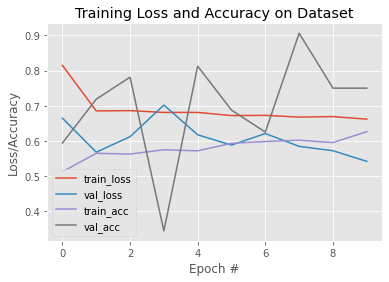

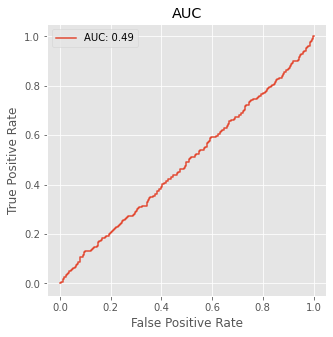

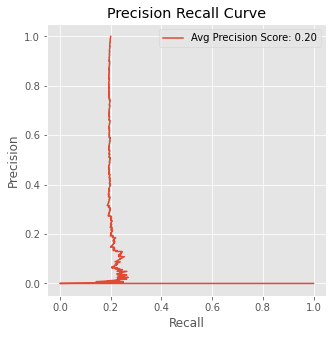

In [49]:
# plot figures
plot_history(history)
plot_auc(val_Y, pred_Y)
precision, recall, thresholds = plot_pr(val_Y, pred_Y)

Once you feel you are done training, you'll need to decide the proper classification threshold that optimizes your model's performance for a given metric (e.g. accuracy, F1, precision, etc.  You decide) 

In [53]:
## Find the threshold that optimize your model's performance,
## and use that threshold to make binary classification. Make sure you take all your metrics into consideration.

# Look at the threshold where precision is 0.8
threshold_value = 0.35
idx = (np.abs(thresholds - threshold_value)).argmin() 
print('Precision is: '+ str(precision[idx]))
print('Recall is: '+ str(recall[idx]))
print('Threshold is: '+ str(thresholds[idx]))
print('F1 Score is: ' + str(calc_f1(precision[idx],recall[idx])))

Precision is: 0.1929480901077375
Recall is: 0.6888111888111889
Threshold is: 0.349681
F1 Score is: 0.30145371078806427


In [54]:
cutoff = thresholds[idx]

In [ ]:
## Let's look at some examples of true vs. predicted with our best model: 

# Todo

fig, m_axs = plt.subplots(10, 10, figsize = (16, 16))
i = 0
for (c_x, c_y, c_ax) in zip(valX[0:100], valY[0:100], m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = 'bone')
    if c_y == 1: 
        if pred_Y[i] > cutoff:
            c_ax.set_title('1, 1')
        else:
            c_ax.set_title('1, 0')
    else:
        if pred_Y[i] > cutoff: 
            c_ax.set_title('0, 1')
        else:
            c_ax.set_title('0, 0')
    c_ax.axis('off')
    i=i+1

In [45]:
## Just save model architecture to a .json:

model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)